In [245]:
# iterate directory to collect list of lists of sentences 
import re
import os
import pandas as pd

# change active directory
os.chdir(".")
base_dir = "./mirza-ghalib"

txt_list = []
#docs_as_list=[]
for dirpath, dirnames, filename in os.walk(base_dir):
    for filename in filename:
        # create full path
        txtfile_full_path = os.path.join(dirpath, filename)
        sentences_as_list=[]
        with open(txtfile_full_path) as f:
             for line in f:
                   stripped_line = line.strip()
                   txt_list.append(stripped_line)
                   #sentences_as_list.append(stripped_line)
             #docs_as_list.append(sentences_as_list)   
                

In [278]:
df = pd.DataFrame(txt_list) 
df.head(5)

,0
0,hai bazm-e-butāñ meñ suḳhan āzurda-laboñ se
1,tañg aa.e haiñ ham aise ḳhushāmad-talaboñ...
2,
3,hai daur-e-qadah vaj.h-e-pareshānī-e-sahbā
4,yak-bār lagā do ḳhum-e-mai mere laboñ se


In [284]:
stop_words = ['ko', 'hai', 'meñ', 'pe', 'bhī', 'kī', 'ki', 'huuñ', 'haiñ', 
              'tak', 'hote', 'hotā', 'ham','tum','yā', 'ho','na','kis', 'se', 'ye',
              'is', 'tujh','mujh', 'kyā', 'phir', 'aur', 'jo', 'vo','kā', 'to', 'aa.e',
              'par', 'mirā', 'tirā','mirī', 'tirī','mere', 'merī', 'tere','mire', 'tire', 'yahī'
              'o', 'ke', 'ai', 'maiñ', 'merā', 'terā', 'terī', 'merį', 'kisī','kab'
              'nahīñ', 'un', 'hua', 'e', 'ne', 'uskā', 'uskī', 'thā', 'thī', 'aisī'
               'huā', 'huī', 'jab', 'tab','ab', 'kab' 'honā', 'aayā', 'gayā','be', 'kuchh',
              'kyoñ','jise', 'kahāñ', 'ga','hi','aanā', 'jaanā', 'koī','hameñ', 'kyuuñ',
              'kar', 'jaa', 'pa', 'do', '\'asad\'', '\'ġhālib\'', 'us','jis','gar','hue',
              'kiye', 'liye', 'tū', 'kiyā', 'ga', 'haa', 'de', 'mujhe', 'tujhe', 'agar',
              'hī', 'rahā', 'iiñ', 'gaa', 'jaa', 'eñ', 'ek', 'ik', 'har', 'aa', 'kare'
              'kahe', 'kaheñ', 'kahte', 'haañ', 'the', 'aati', 'hā', 'yuuñ', 'pā', 'ba',
               'jā', 'kaun', 'yahī', 'vahī', 'aap', 'kare', 'apnā', 'vaañ', 'aatī', 'jātī', 
              'nā', 'le', 'nahīñ', 'so', 'apnā', 'huā']

def remove_stopWords(s):
    '''For removing stop words
    '''
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

def remove_connected_words(s):
    '''For removing connected words
    '''
    s = ' '.join(word for word in s.split("-"))
    return s

def connect_words(s):
    '''For removing connected words
    '''
    s = s.replace(".", "")
    return s

only_cleaned_connected_words = df[0].apply(lambda x: remove_connected_words(x))
removed_connected_stop_words = only_cleaned_connected_words.apply(lambda x: remove_stopWords(x))
removed_connected_stop_words = removed_connected_stop_words.apply(lambda x: connect_words(x))
removed_connected_stop_words

0        bazm butāñ suḳhan āzurda laboñ
1           tañg aise ḳhushāmad talaboñ
2                                      
3       daur qadah vajh pareshānī sahbā
4           yak bār lagā ḳhum mai laboñ
                     ...               
5571                ġharīb ġharīb navāz
5572                                   
5573                  ullāh ḳhaañ tamām
5574            dareġhā rind shāhid bāz
5575                                   
Name: 0, Length: 5576, dtype: object

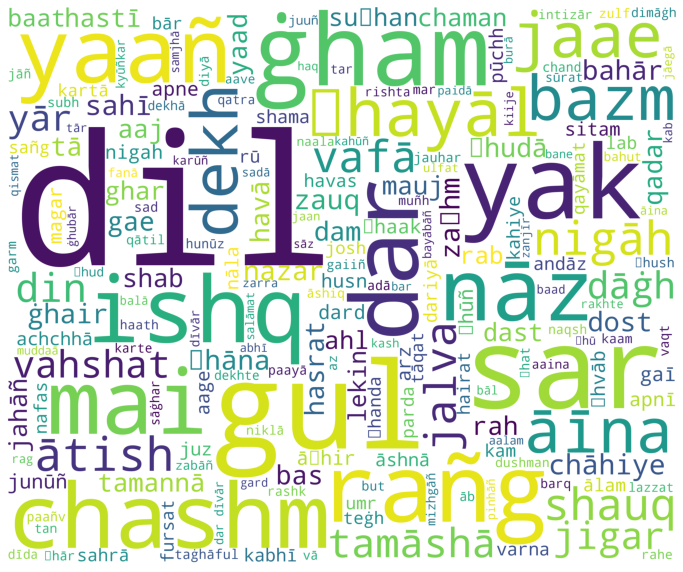

In [285]:
# wordcloud
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
all_words = ' '.join(only_cleaned_connected_words)
all_words_minus_stop = ' '.join(removed_connected_stop_words)
cleaned_words = " ".join([word for word in all_words.split()])
cleaned_words_minus_stop = " ".join([word for word in all_words_minus_stop.split()])
wordcloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=3000,
                      height=2500
                      ).generate(cleaned_words_minus_stop)
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [286]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def visualize_ngram(input_data,n=2, max_number=10, title_pre="Ghazal"):
    """ 
    Input data should be a list of docs.
    Each doc is represented by one whole string (with preprocessing, eg.remove markups)    
    """
    # Plot configuration
    plt.style.use("ggplot")
    plt.rcParams['axes.titlesize'] = 32
    plt.rcParams['figure.figsize'] = (20.0, 5.0)
    plt.rcParams['xtick.labelsize'] = 22   
    
    vectorizer = CountVectorizer(ngram_range=(n,n), max_features=max_number,stop_words=stop_words)
    TITLE = title_pre+" - "+"Top " + str(n) + "-Grams"
        
    mat = vectorizer.fit_transform(input_data)
    
    pd.DataFrame(mat.sum(axis=0).T,
             index=vectorizer.get_feature_names(),
             columns=['freq']).sort_values(by='freq',
                                           ascending=False).plot(kind='bar',title=TITLE)

/Users/uday.kamath/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['asad', 'ġhālib'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


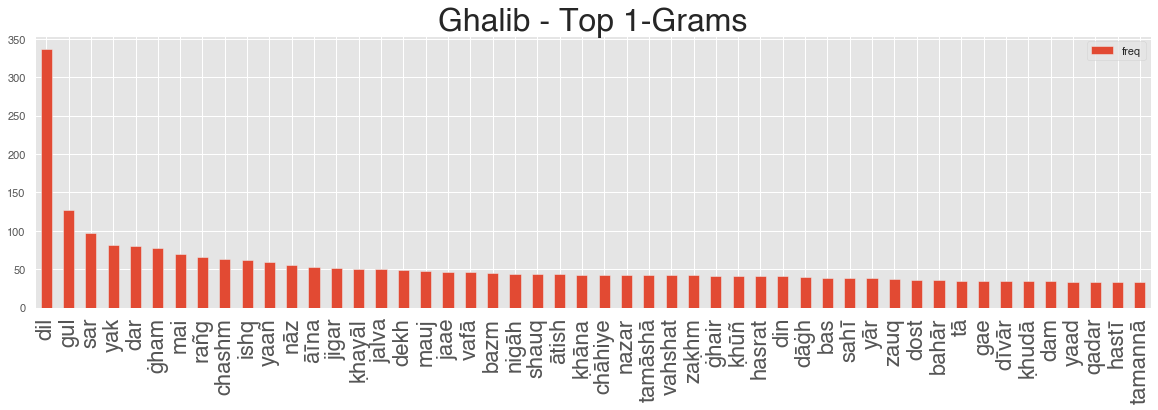

In [288]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

visualize_ngram(removed_connected_stop_words,1,50,"Ghalib")
plt.show()

In [289]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def build_topic_model(input_data,number_of_topics=4, n=1, title_pre="Ghazal"):
    
    
    vectorizer = CountVectorizer(ngram_range=(n,n), stop_words=stop_words)
    TITLE = title_pre+" - "+"Top " + str(n) + "-Grams"
        
    dtm = vectorizer.fit_transform(input_data)
    feature_names = vectorizer.get_feature_names()
    
    # Run LDA
    lda = LatentDirichletAllocation(n_components=number_of_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(dtm)
    
    # display
    display_topics(lda, feature_names,10)
    
    return lda, vectorizer,dtm

In [290]:
lda, vectorizer, dtm = build_topic_model(removed_connected_stop_words)


/Users/uday.kamath/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['asad', 'ġhālib'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic 0:
sar gul dar rañg yaañ ḳhayāl jaae nazar yaad ḳhudā
Topic 1:
dil mai chashm jigar gul vafā dost tamāshā zaḳhm gae
Topic 2:
chāhiye din bazm nigāh ḳhāna bas ghar āshnā dard baat
Topic 3:
dil ġham ishq āīna yak vahshat hasrat bahār zauq yār


In [291]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, dtm, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.170527  0.005562       1        1  28.402571
0      0.203411 -0.129995       2        1  25.596036
3     -0.102801 -0.108215       3        1  23.205745
2      0.069918  0.232648       4        1  22.795648, topic_info=        Term        Freq       Total Category  logprob  loglift
749      dil  276.000000  276.000000  Default  30.0000  30.0000
2902     sar   81.000000   81.000000  Default  29.0000  29.0000
3894    ġham   60.000000   60.000000  Default  28.0000  28.0000
652      dar   58.000000   58.000000  Default  27.0000  27.0000
1312    ishq   51.000000   51.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
2889  samjhā   16.284464   17.079094   Topic4  -5.4818   1.4310
1755     lab   17.546885   18.657305   Topic4  -5.4072   1.4172
318      bas   26.607529   31.166245   Topic4  -4.9908   1.3205
2348    nāla   17.346727   20.020856   Topic4  -5.4186   1.3352
2368     nāz   20.521446   43.685543   Topic4  -5.2506   0.7231

[180 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
11        2  0.954150     aage
17        2  0.946944    aaina
53        4  0.959940  achchhā
91        2  0.976949      ahl
133       3  0.974069    andāz
...     ...       ...      ...
4037      1  0.957442    ḳhvāb
4062      4  0.992248    ḳhāna
4078      4  0.952862      ḳhū
4090      2  0.305362     ḳhūñ
4090      3  0.666244     ḳhūñ

[175 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])